In [4]:
# Preamble: minimal imports + local include
using Random
using Statistics
using Printf
using Plots
using Logging

if !isdefined(Main, :System1D)
    include("../src/System1D.jl")
end
using .System1D: Hamiltonian, TrialWF, Walker, DMCParams, DMCSim, ImportanceGuiding, run_simulation!, plot_snapshot_1d_density


## System: 1D Harmonic Oscillator with Importance Sampling

**Potential**
$$ V(x) = \frac{1}{2} x^2 $$

**Trial wavefunction (Gaussian)**
$$ \psi_T(x) = e^{-\alpha x^2 / 2} $$

This cell defines the Hamiltonian and trial wavefunction, initializes walkers, and runs importance-sampled DMC.


In [5]:
# System: 1D harmonic oscillator with importance sampling
V(R) = 0.5 * R[1]^2
H = Hamiltonian(1, 0.5, V)

alpha = 1.0
logpsi(R) = -0.5 * alpha * R[1]^2
gradlogpsi(R) = [-alpha * R[1]]
lapllogpsi(R) = -alpha

trial = TrialWF(logpsi, gradlogpsi, lapllogpsi)
guiding = ImportanceGuiding(trial, H)

# Walkers and params
targetN = 5000
walkers = [Walker([2 * rand() - 1]) for _ in 1:targetN]

params = DMCParams(0.005, 400, 50, targetN, 0.5, 0.1, 10, 50)

# Run
rng_sim = MersenneTwister(42)
sim = DMCSim(H, params, walkers, rng_sim; guiding=guiding)
run_simulation!(sim; snapshot_steps=[params.nsteps])

ET_history = sim.ET_history
population_history = sim.population_history
energy_mean_history = sim.energy_mean_history
energy_variance_history = sim.energy_variance_history

nothing


## Results

**Exact ground-state energy**
$$ E_0 = \frac{1}{2} \; \text{(a.u.)} $$

This cell reports the post-equilibration energy and plots the reference energy, population, mean local energy, and local-energy variance over time, plus the final walker density.


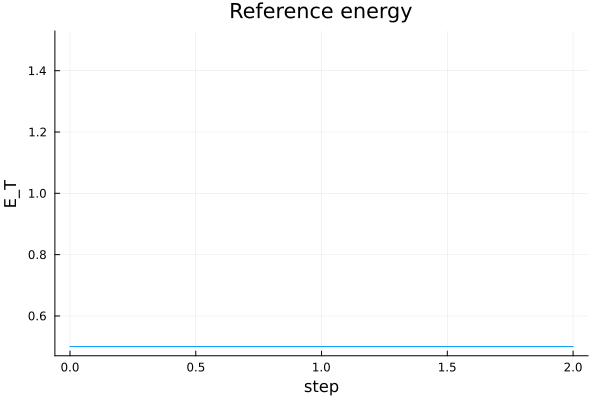

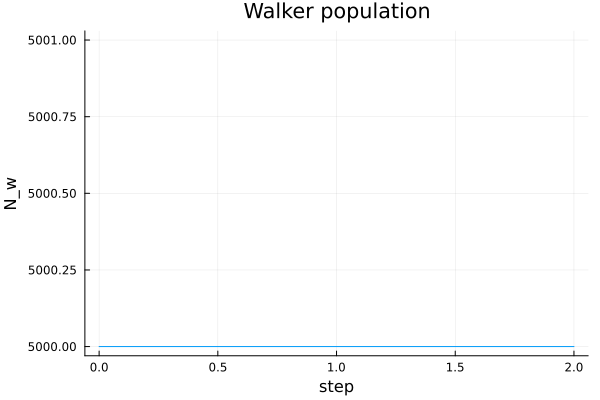

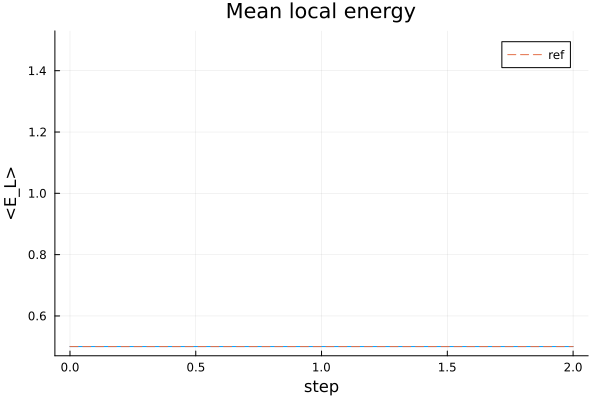

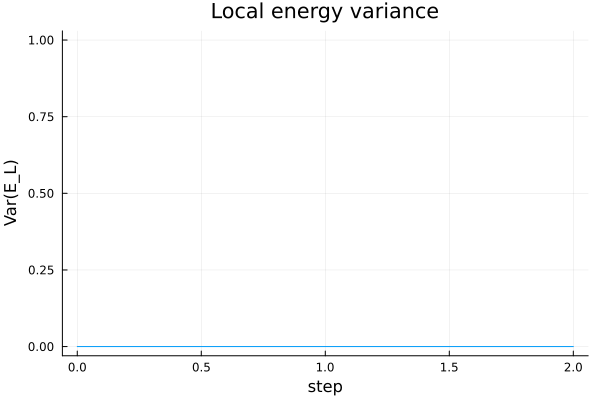

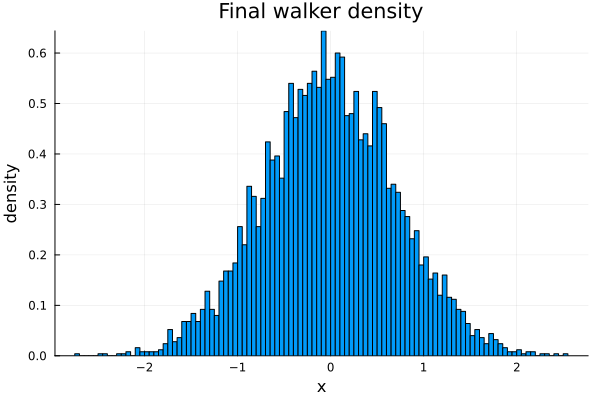

HO DMC (IS) energy (post-eq, nequil=50): E = 0.500000 +/- 0.000000
Final step: E = 0.500000, Var(E_L) = 0.000000
Reference energy: 0.500000


In [6]:
# Results and plots
t = (0:params.nsteps) .* params.dt
E_ref = 0.5

nequil = params.nequil
start_idx = min(nequil + 1, length(energy_mean_history))
postE = energy_mean_history[start_idx:end]

Ebar = mean(postE)
SEM = (length(postE) > 1) ? std(postE) / sqrt(length(postE)) : NaN

println(@sprintf("HO DMC (IS) energy (post-eq, nequil=%d): E = %.6f +/- %.6f", nequil, Ebar, SEM))
println(@sprintf("Final step: E = %.6f, Var(E_L) = %.6f", energy_mean_history[end], energy_variance_history[end]))
println(@sprintf("Reference energy: %.6f", E_ref))


Logging.with_logger(Logging.NullLogger()) do
    redirect_stderr(devnull) do
        p1 = plot(t, ET_history, xlabel="step", ylabel="E_T", title="Reference energy", label=false)
        display(p1)
        
        p2 = plot(t, population_history, xlabel="step", ylabel="N_w", title="Walker population", label=false)
        display(p2)
        
        p3 = plot(t, energy_mean_history, xlabel="step", ylabel="<E_L>", title="Mean local energy", label=false)
        plot!(p3, [t[1], t[end]], [E_ref, E_ref], ls=:dash, label="ref")
        display(p3)
        
        p4 = plot(t, energy_variance_history, xlabel="step", ylabel="Var(E_L)", title="Local energy variance", label=false)
        display(p4)
        
        if !isempty(sim.walker_positions_history)
            snap = sim.walker_positions_history[end]
            p5 = plot_snapshot_1d_density(snap; nbins=120, title="Final walker density")
            display(p5)
        end
    end
end
